**Task 3: (necessary to pass the project) Consider a more sophisticated model using an interesting real-world dataset (here the MNIST dataset), Quanvolutional
Neural Networks. Work through the example, Implement and present your
steps in a notebook and comment on the important steps.**

Task 3 by :***Yash Oza***

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.0 MB/s eta 0:00:00


# Importing the Libraries

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Loading the Fashion MNIST data

In [ ]:
mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Loading the device to run the circuits on

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# In the below function:
    1. image is divided into 2 x 2 pixels
    2. quantum circuit processed the individual squares
    3. Mapping the expectation values with the channels

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Preprocessing the images using quantum methods

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


# Visualizing the data after quantum preprocess

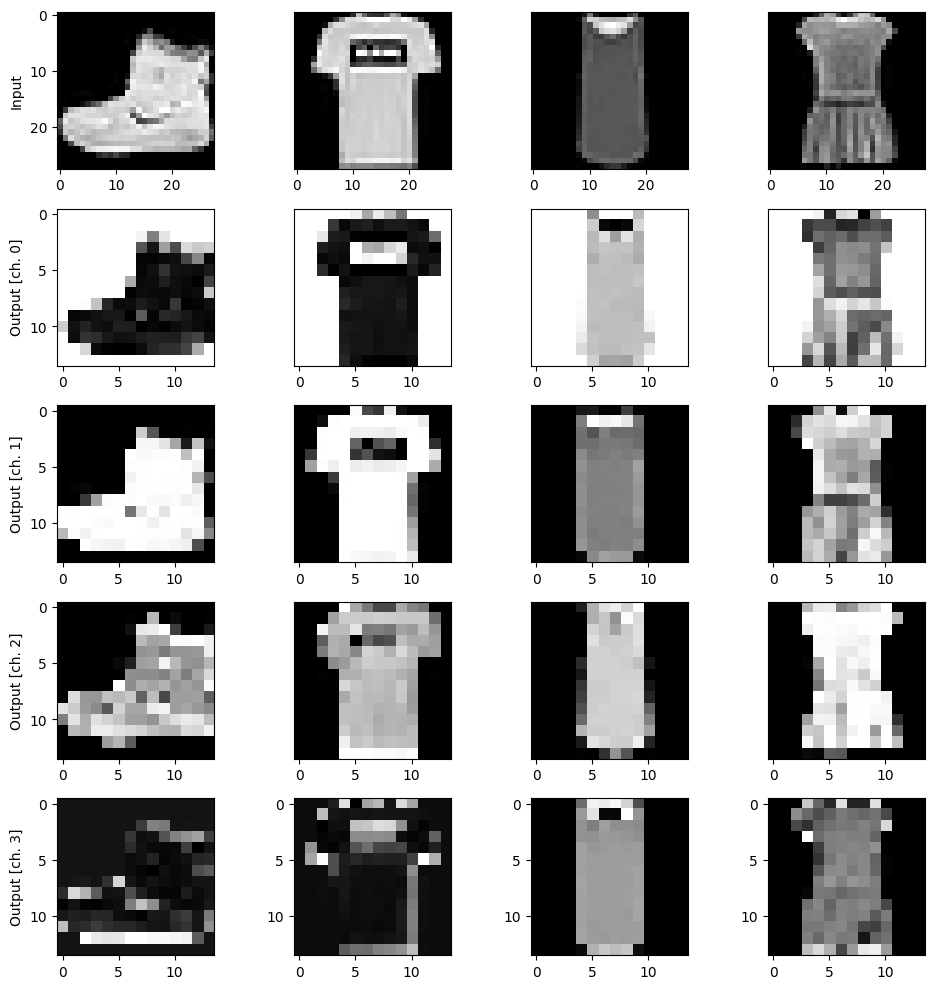

In [ ]:
# Plotting the images after quantum pre-processing and noticing the changes

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Defining the Hybrid quantum-classical Model

In [ ]:
# Defining the model consisting of a dence layer with 10 nodes as they're the total classes in fashion MNIST.

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Training the Model

# Training and testing on data with quantum pre-processing

In [ ]:
# Training the model with quantum pre processing

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - 228ms/step - accuracy: 0.1000 - loss: 2.6638 - val_accuracy: 0.2333 - val_loss: 2.1291
Epoch 2/30
13/13 - 0s - 11ms/step - accuracy: 0.4400 - loss: 1.4987 - val_accuracy: 0.3333 - val_loss: 1.7232
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.6200 - loss: 1.0671 - val_accuracy: 0.6000 - val_loss: 1.3603
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7800 - loss: 0.8047 - val_accuracy: 0.5667 - val_loss: 1.2327
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 0.6369 - val_accuracy: 0.6000 - val_loss: 1.1870
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.8800 - loss: 0.5283 - val_accuracy: 0.6000 - val_loss: 1.1379
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.4481 - val_accuracy: 0.6000 - val_loss: 1.1026
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.3859 - val_accuracy: 0.6000 - val_loss: 1.0862
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.3366 - val_accuracy: 0.6000 - val_loss: 1.0763
Epoch 10/30
1

# Training and testing on data without quantum pre-processing

In [ ]:
# Training the model on classical data

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 144ms/step - accuracy: 0.1600 - loss: 2.3648 - val_accuracy: 0.1667 - val_loss: 2.1091
Epoch 2/30
13/13 - 1s - 103ms/step - accuracy: 0.4600 - loss: 1.6843 - val_accuracy: 0.2000 - val_loss: 1.8225
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5400 - loss: 1.3774 - val_accuracy: 0.3000 - val_loss: 1.5453
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7600 - loss: 1.1381 - val_accuracy: 0.3667 - val_loss: 1.3658
Epoch 5/30
13/13 - 0s - 7ms/step - accuracy: 0.8400 - loss: 0.9663 - val_accuracy: 0.5000 - val_loss: 1.2531
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 0.8433 - val_accuracy: 0.5333 - val_loss: 1.1740
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9200 - loss: 0.7491 - val_accuracy: 0.6000 - val_loss: 1.1126
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.6741 - val_accuracy: 0.6000 - val_loss: 1.0647
Epoch 9/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.6132 - val_accuracy: 0.5667 - val_loss: 1.0271
Epoch 10/30

# Results

<ipython-input-14-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


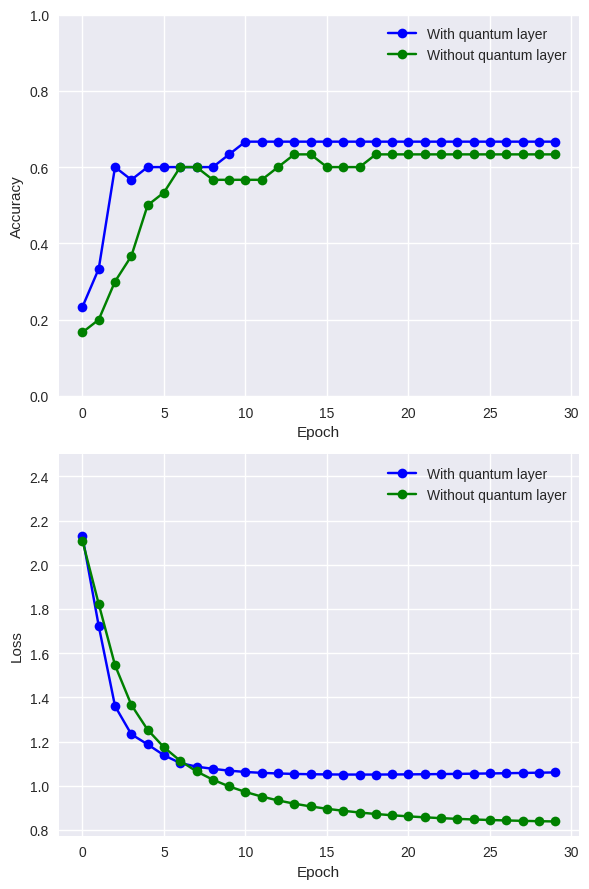

In [ ]:
# plotting the accuracy and loss

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

**From the graphs obtained we can see that the quantum preprocessing has helped the model give a better performance than the classicial data**

Completed Task 3 for the conspicuity project

**Yash Oza**